In [1]:
import src.test_functions as test_functions

In [2]:
import scipy
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1'

In [5]:
import torch.nn as nn
import torch

from tqdm import tqdm

In [6]:
from sympy import symbols, Max
import sympy

In [7]:
from pyibex import Interval, IntervalVector, Function, CtcFwdBwd, SepFwdBwd, GEQ

In [8]:
seed = 123

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##  Sample points for training

In [9]:
def sample(function, bounds, n, local_minima=False):
    assert isinstance(bounds, np.ndarray)
    assert bounds.shape[1] == 2
    xs = np.random.rand(n, bounds.shape[0]) * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
    ys = np.array([function(x).item() for x in xs])
    
    if local_minima:
        xs_local_opt = []
        ys_local_opt = []
        for x0 in xs:
            opt_res = scipy.optimize.minimize(func, x0, method='Nelder-Mead')
            if opt_res.success:
                xs_local_opt.append(opt_res.x)
                ys_local_opt.append(opt_res.fun)
        xs_local_opt, ys_local_opt = np.array(xs_local_opt), np.array(ys_local_opt)
        return xs, ys, xs_local_opt, ys_local_opt
    
    return xs, ys

In [10]:
dimension = 1

func = test_functions.Ackley(dims=dimension)
# variables, expression = func.expression()

bounds = func.get_default_domain()
lb = bounds.T[0]
ub = bounds.T[1]

In [11]:
xs = np.arange(lb[0], ub[0], 0.01)
ys = np.array([func(np.array([x])).item() for x in xs])

# sampled_xs, sampled_ys = sample(func, bounds, 100)
sampled_xs, sampled_ys, sampled_xs_local_min, sampled_ys_local_min = sample(func, bounds, 100, local_minima=True)

/home/zhizhen/anaconda3/envs/mcmm/lib/python3.9/site-packages/numpy/core/getlimits.py:511: UserWarning: Signature b'\xcc\xcc\xcc\xbd' for <class 'numpy.float32'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/zhizhen/anaconda3/envs/mcmm/lib/python3.9/site-packages/numpy/core/_machar.py:295: RuntimeWarning: overflow encountered in divide
  xmax = xmax / (xmin*beta*beta*beta)


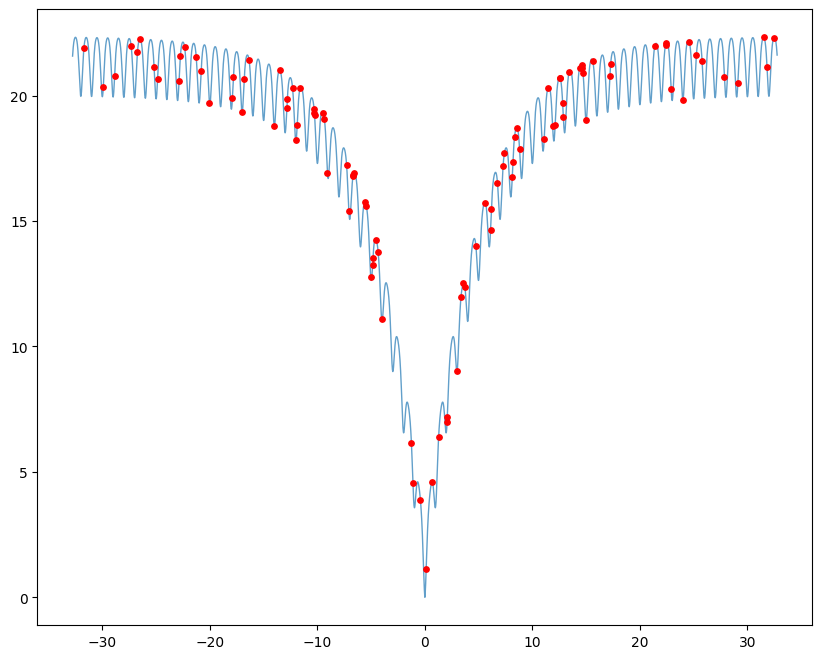

In [12]:
fig = plt.figure(figsize=(10,8))
plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


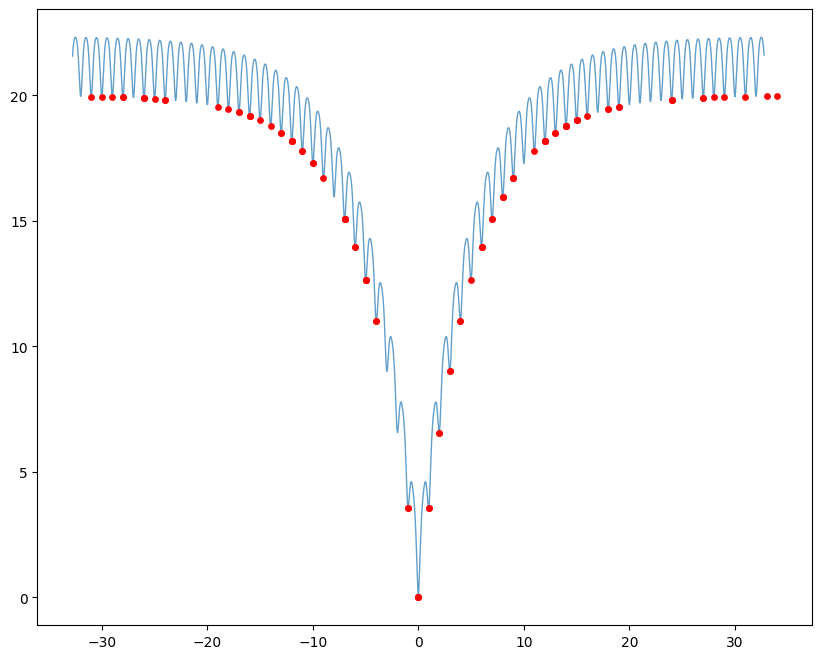

In [13]:
fig = plt.figure(figsize=(10,8))
# plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


## Fit a neural network

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
xs_train = sampled_xs
ys_train = np.expand_dims(sampled_ys, axis=1)

In [16]:
hidden_dim = 16

model = nn.Sequential(
    nn.Linear(dimension, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1)
)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 9000

model.to(device)

loss_record = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    x_train_tensor = torch.FloatTensor(xs_train).to(device)
    y_train_tensor = torch.FloatTensor(ys_train).to(device)
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    loss_record.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

100%|█████████████████████████████████████| 9000/9000 [00:04<00:00, 2106.78it/s]


In [19]:
with torch.no_grad():
    fitted_ys = model(torch.FloatTensor(np.expand_dims(xs, axis=1)).to(device)).detach().cpu().squeeze().numpy()

In [20]:
abs(ys - fitted_ys)

array([1.07006836, 1.00051308, 0.93490028, ..., 3.47109222, 3.53765488,
       3.60816193])

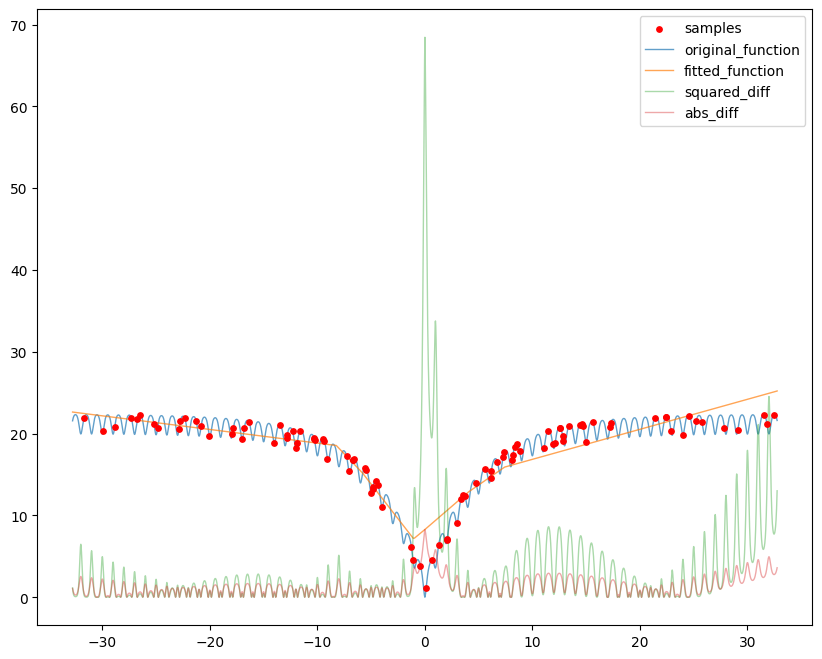

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(xs_train[:, 0], ys_train[:, 0], s=15, c='red', zorder=10, label="samples")
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

ax.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7, label="original_function")
ax.plot(xs, fitted_ys, linewidth=1, alpha=0.7, label="fitted_function")

y_diff_squared = (ys - fitted_ys) ** 2
ax.plot(xs, y_diff_squared, linewidth=1, alpha=0.4, label="squared_diff")

y_diff_abs = abs(ys - fitted_ys)
ax.plot(xs, y_diff_abs, linewidth=1, alpha=0.4, label="abs_diff")

ax.legend()

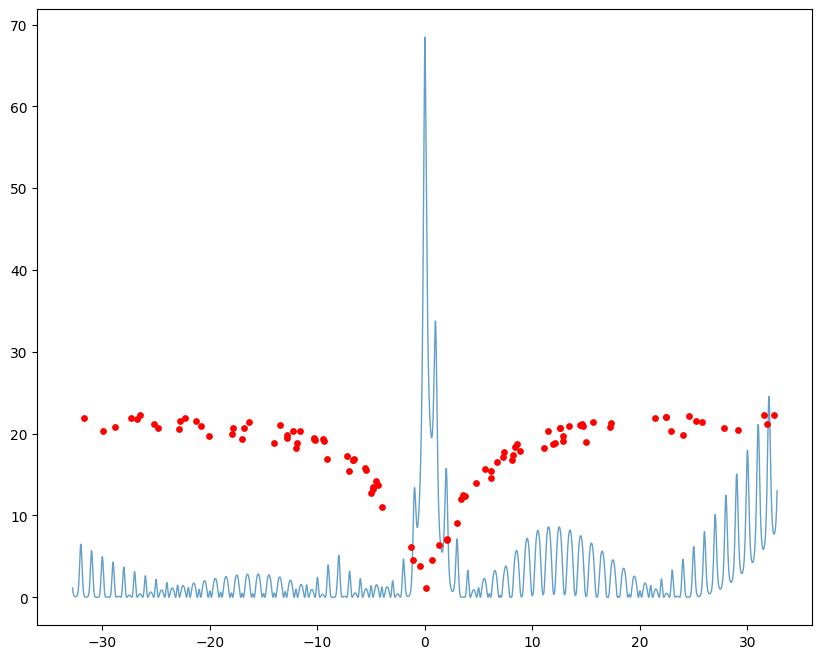

In [22]:
fig = plt.figure(figsize=(10,8))

plt.scatter(xs_train[:, 0], ys_train[:, 0], s=15, c='red', zorder=10)
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

y_diff_squared = (ys - fitted_ys) ** 2
plt.plot(xs, y_diff_squared, linewidth=1, alpha=0.7)

## Convert the neural network to ibex expression (through sympy) 

In [23]:
layer_idx = 2
layer = model[layer_idx]

In [24]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [25]:
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [26]:
inter_vars

(x[2][0],
 x[2][1],
 x[2][2],
 x[2][3],
 x[2][4],
 x[2][5],
 x[2][6],
 x[2][7],
 x[2][8],
 x[2][9],
 x[2][10],
 x[2][11],
 x[2][12],
 x[2][13],
 x[2][14],
 x[2][15])

In [27]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [28]:
W = weight.detach().cpu().numpy()

In [29]:
b = bias.detach().cpu().numpy()
b

array([1.3982359], dtype=float32)

In [30]:
expression = (W @ X).squeeze(axis=1) + b
expression = expression.item()

In [31]:
layer_idx = 1
layer = model[layer_idx]
layer

ReLU()

In [32]:
prev_inter_vars = inter_vars
width = len(inter_vars)
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [33]:
inter_vars[0]

x[1][0]

In [34]:
replace_dict = {}
for curr_var, prev_var in zip(inter_vars, prev_inter_vars):
    replace_dict[prev_var] = Max(curr_var, 0)

In [35]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [36]:
expression

0.419926673173904*Max(0, x[1][0]) + 0.460548758506775*Max(0, x[1][10]) + 0.582288801670074*Max(0, x[1][11]) - 0.41609525680542*Max(0, x[1][12]) + 0.284910440444946*Max(0, x[1][13]) + 0.987527906894684*Max(0, x[1][14]) + 1.11243760585785*Max(0, x[1][15]) + 1.32002556324005*Max(0, x[1][1]) + 0.534321367740631*Max(0, x[1][2]) + 0.333724439144135*Max(0, x[1][3]) - 1.21847856044769*Max(0, x[1][4]) + 0.271106153726578*Max(0, x[1][5]) - 1.69371867179871*Max(0, x[1][6]) + 0.053694237023592*Max(0, x[1][7]) + 0.161109372973442*Max(0, x[1][8]) - 0.608020067214966*Max(0, x[1][9]) + 1.39823591709137

In [37]:
layer_idx = 0
layer = model[layer_idx]
layer

Linear(in_features=1, out_features=16, bias=True)

In [38]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [39]:
prev_inter_vars = inter_vars
inter_vars = symbols(', '.join(['x[{}]'.format(i) for i in range(width)]))
if isinstance(inter_vars, sympy.Symbol):
    inter_vars = [inter_vars]

In [40]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [41]:
W = weight.detach().cpu().numpy()

In [42]:
b = bias.detach().cpu().numpy()
b

array([-0.78218615,  3.2335644 , -0.86286646,  0.9805956 ,  3.2857184 ,
        1.1941917 , -5.861835  , -0.20343792, -0.8257255 ,  3.124097  ,
       -1.1371391 ,  0.88599545,  2.1923983 , -1.0529473 ,  4.3091745 ,
        3.6009738 ], dtype=float32)

In [43]:
mat_res = (W @ X).squeeze(axis=1) + b

In [44]:
replace_dict = {}
for curr_expr, prev_var in zip(mat_res, prev_inter_vars):
    replace_dict[prev_var] = curr_expr
replace_dict

{x[1][0]: -0.747922241687775*x[0] - 0.782186150550842,
 x[1][1]: 3.23356437683105 - 0.081346370279789*x[0],
 x[1][2]: -0.812121331691742*x[0] - 0.862866461277008,
 x[1][3]: 0.881996512413025*x[0] + 0.980595588684082,
 x[1][4]: 3.28571844100952 - 0.444269627332687*x[0],
 x[1][5]: 1.07397019863129*x[0] + 1.19419169425964,
 x[1][6]: -0.711448669433594*x[0] - 5.86183500289917,
 x[1][7]: -1.18230283260345*x[0] - 0.203437924385071,
 x[1][8]: -0.826471269130707*x[0] - 0.825725495815277,
 x[1][9]: 0.532816588878632*x[0] + 3.12409710884094,
 x[1][10]: -1.18594014644623*x[0] - 1.13713908195496,
 x[1][11]: 0.796885371208191*x[0] + 0.885995447635651,
 x[1][12]: 2.19239830970764 - 0.549656271934509*x[0],
 x[1][13]: -1.02349781990051*x[0] - 1.05294728279114,
 x[1][14]: 4.30917453765869 - 0.132146805524826*x[0],
 x[1][15]: 3.6009738445282 - 0.109011173248291*x[0]}

In [45]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [46]:
str(expression)

'-0.41609525680542*Max(0, 2.19239830970764 - 0.549656271934509*x[0]) + 1.32002556324005*Max(0, 3.23356437683105 - 0.081346370279789*x[0]) - 1.21847856044769*Max(0, 3.28571844100952 - 0.444269627332687*x[0]) + 1.11243760585785*Max(0, 3.6009738445282 - 0.109011173248291*x[0]) + 0.987527906894684*Max(0, 4.30917453765869 - 0.132146805524826*x[0]) + 0.460548758506775*Max(0, -1.18594014644623*x[0] - 1.13713908195496) + 0.053694237023592*Max(0, -1.18230283260345*x[0] - 0.203437924385071) + 0.284910440444946*Max(0, -1.02349781990051*x[0] - 1.05294728279114) + 0.161109372973442*Max(0, -0.826471269130707*x[0] - 0.825725495815277) + 0.534321367740631*Max(0, -0.812121331691742*x[0] - 0.862866461277008) + 0.419926673173904*Max(0, -0.747922241687775*x[0] - 0.782186150550842) - 1.69371867179871*Max(0, -0.711448669433594*x[0] - 5.86183500289917) - 0.608020067214966*Max(0, 0.532816588878632*x[0] + 3.12409710884094) + 0.582288801670074*Max(0, 0.796885371208191*x[0] + 0.885995447635651) + 0.3337244391441

In [47]:
variables, func_expr = func.expression()

In [48]:
func_expr

' (-(20) * exp(-(0.2)*sqrt(( + (x[0]^2)) / 1))) + ( - exp(( + cos((6.283185307179586)*x[0])) / 1)) + ( + (20) + exp(1.0) )'

### (Finally..) prune the box

In [49]:
expr_nn = str(expression).replace("Max", "max")

In [50]:
expr_nn

'-0.41609525680542*max(0, 2.19239830970764 - 0.549656271934509*x[0]) + 1.32002556324005*max(0, 3.23356437683105 - 0.081346370279789*x[0]) - 1.21847856044769*max(0, 3.28571844100952 - 0.444269627332687*x[0]) + 1.11243760585785*max(0, 3.6009738445282 - 0.109011173248291*x[0]) + 0.987527906894684*max(0, 4.30917453765869 - 0.132146805524826*x[0]) + 0.460548758506775*max(0, -1.18594014644623*x[0] - 1.13713908195496) + 0.053694237023592*max(0, -1.18230283260345*x[0] - 0.203437924385071) + 0.284910440444946*max(0, -1.02349781990051*x[0] - 1.05294728279114) + 0.161109372973442*max(0, -0.826471269130707*x[0] - 0.825725495815277) + 0.534321367740631*max(0, -0.812121331691742*x[0] - 0.862866461277008) + 0.419926673173904*max(0, -0.747922241687775*x[0] - 0.782186150550842) - 1.69371867179871*max(0, -0.711448669433594*x[0] - 5.86183500289917) - 0.608020067214966*max(0, 0.532816588878632*x[0] + 3.12409710884094) + 0.582288801670074*max(0, 0.796885371208191*x[0] + 0.885995447635651) + 0.3337244391441

In [51]:
variables

['x[1]']

In [52]:
def expression_squared_diff(expr1, expr2):
    return "(({}) - ({})) ^ 2".format(expr1, expr2)

In [53]:
def expression_absolute_diff(expr1, expr2):
    return "abs(({}) - ({}))".format(expr1, expr2)

In [54]:
def expression_add_const(expr, const):
    return "({}) + ({})".format(expr, const)

In [55]:
ibex_expression = expression_squared_diff(func_expr, expr_nn)

In [91]:
ibex_expression = expression_absolute_diff(func_expr, expr_nn)

In [92]:
ibex_expression = expression_add_const(ibex_expression, -40)

In [93]:
ibex_expression

'(abs(( (-(20) * exp(-(0.2)*sqrt(( + (x[0]^2)) / 1))) + ( - exp(( + cos((6.283185307179586)*x[0])) / 1)) + ( + (20) + exp(1.0) )) - (-0.41609525680542*max(0, 2.19239830970764 - 0.549656271934509*x[0]) + 1.32002556324005*max(0, 3.23356437683105 - 0.081346370279789*x[0]) - 1.21847856044769*max(0, 3.28571844100952 - 0.444269627332687*x[0]) + 1.11243760585785*max(0, 3.6009738445282 - 0.109011173248291*x[0]) + 0.987527906894684*max(0, 4.30917453765869 - 0.132146805524826*x[0]) + 0.460548758506775*max(0, -1.18594014644623*x[0] - 1.13713908195496) + 0.053694237023592*max(0, -1.18230283260345*x[0] - 0.203437924385071) + 0.284910440444946*max(0, -1.02349781990051*x[0] - 1.05294728279114) + 0.161109372973442*max(0, -0.826471269130707*x[0] - 0.825725495815277) + 0.534321367740631*max(0, -0.812121331691742*x[0] - 0.862866461277008) + 0.419926673173904*max(0, -0.747922241687775*x[0] - 0.782186150550842) - 1.69371867179871*max(0, -0.711448669433594*x[0] - 5.86183500289917) - 0.608020067214966*max(0,

In [94]:
f = Function(*variables, ibex_expression)
X_in = IntervalVector(Interval(-10, 10))

In [95]:
ctc = CtcFwdBwd(f, GEQ)  # root is when f = 0
ctc.contract(X_in)

In [96]:
X_in

([-1.521978847410848, 1.521978847410848])